train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

Destination - The planet the passenger will be debarking to.

Age - The age of the passenger.

VIP - Whether the passenger has paid for special VIP service during the voyage.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the 
    Spaceship Titanic's many luxury amenities.

Name - The first and last names of the passenger.

Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set. 

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
df = pd.read_csv('train.csv')
column_alias = {
    'PassengerId': 'id', 'HomePlanet': 'home', 'CryoSleep': 'is_cryo', 'Cabin': 'cab', 'Destination': 'dest', 
    'Age': 'age',
    'VIP': 'vip', 'RoomService': 'has_room', 'FoodCourt': 'has_food', 'ShoppingMall':'has_shop',
    'Spa': 'has_spa', 'VRDeck': 'has_vrd',
    'Name': 'name', 'Transported': 'target'
}
df = df.rename(columns=column_alias)    

df['family'] = df['id'].apply(lambda x: x.split('_')[0])
df = df.astype({'target': 'int32'})
decks = {'A': 1, 'B': 2, 'C':3, 'D':4,'E':5, 'F':6, 'G':7, 'T':8}
sides = {'P':0, 'S':1}
df['fcab'] = df['cab']
def resolve_cab(row):
    x = row['fcab']
    if isinstance(x, str) and x.find('/') != -1 and len(x.split('/')) == 3:
        res = x.split('/')
        deck, num, side = decks.get(res[0]), int(res[1]), sides.get(res[2])
        return  deck, num, side
    else:
        return None, None, None   


    
# Оператор *: захват элементов во время распаковки кортежа (tuple)
df["deck"], df["num"], df['side'] = zip(*df.apply(resolve_cab, axis=1))

df['famount'] = 1
df['fhome'] = df['home']
df['fdest'] = df['dest']


def count_relatives(x):
    return df[df['family'] == x].shape[0]

def by_relatives(x, key):
    try:
        res = df[(df['family']==x)&(~pd.isna(df[key]))][key].values[0]
        return res
    except IndexError:
        return np.nan


df['famount'] = df['family'].apply(lambda x: count_relatives(x))
df['fcab'] = df.loc[:,['cab', 'family']].apply(lambda x: by_relatives(x[1], 'cab') if pd.isna(x[0]) else x[0], axis=1)


# проставим расходы 0 где is_cryo (если спит значит не тратит, если не тратит  это еще не значит что спит)
for key in ['has_room', 'has_food', 'has_shop', 'has_spa', 'has_vrd']:
    df[key] = df.loc[:, [key, 'is_cryo']].apply(lambda x: 0.0 if x[1] else x[0], axis=1)
    

def set_total(row):
    all_nan = True
    
    total = 0
    for key in ['has_room', 'has_food', 'has_shop', 'has_spa', 'has_vrd']:
        if not pd.isna(row[key]):
            total += row[key]
            all_nan = False    
    return total if not all_nan else np.nan    
df['no_expenses'] = np.nan
df['no_expenses'] = df.apply(lambda x: int(set_total(x) == 0.), axis=1)
# Заполним пропущенные Home и Destination по родственникам

df['fhome'] = df.loc[:,['home', 'family']].apply(lambda x: by_relatives(x[1], 'home') if pd.isna(x[0]) else x[0], axis=1)
df['fdest'] = df.loc[:,['dest', 'family']].apply(lambda x: by_relatives(x[1], 'dest') if pd.isna(x[0]) else x[0], axis=1)


df.head()

,id,home,is_cryo,cab,dest,age,vip,has_room,has_food,has_shop,...,target,family,fcab,deck,num,side,famount,fhome,fdest,no_expenses
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0,0001,B/0/P,2.0,0.0,-1.0,1,Europa,TRAPPIST-1e,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,1,0002,F/0/S,6.0,0.0,1.0,1,Earth,TRAPPIST-1e,0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,0,0003,A/0/S,1.0,0.0,1.0,2,Europa,TRAPPIST-1e,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,0,0003,A/0/S,1.0,0.0,1.0,2,Europa,TRAPPIST-1e,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,1,0004,F/1/S,6.0,1.0,1.0,1,Earth,TRAPPIST-1e,0


In [4]:
df.isnull().sum()

id               0
home           201
is_cryo        217
cab            199
dest           182
age            179
vip            203
has_room       111
has_food       110
has_shop       104
has_spa        113
has_vrd        119
name           200
target           0
family           0
fcab            99
deck           199
num            199
side           199
famount          0
fhome          111
fdest          103
no_expenses      0
dtype: int64

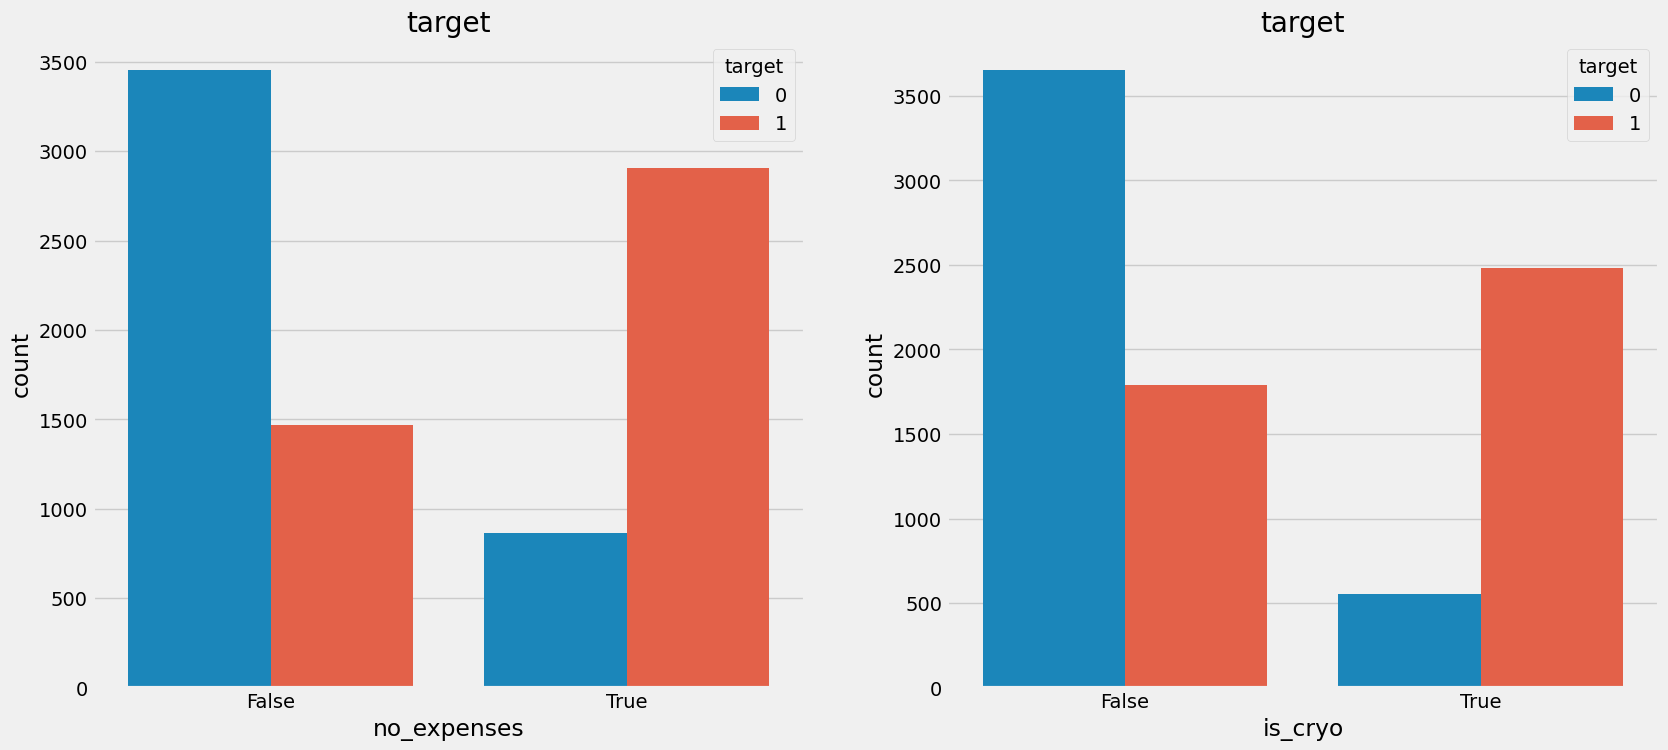

In [357]:
# можно повыкидывать столбцы про криосон и столбцы с расходами, оставив no_expences
# f,ax=plt.subplots(1,2,figsize=(18,8))
# sns.countplot(x=df['no_expenses'], hue=df['target'], ax=ax[0])
# ax[0].set_title('target')
# sns.countplot(x=df['is_cryo'], hue=df['target'], ax=ax[1])
# ax[1].set_title('target')
# plt.show()

In [314]:
# Исследование сколько кают занимают члены одной семьи
# df[df['famount'] == 2].groupby(['deck','side', 'num', 'family', 'famount'])['target'].agg(['sum'])
# df[df['famount'] == 7].groupby(['family', 'famount'])['cab'].agg(['nunique', 'sum'])
# df_temp = df[df['famount'] >0].groupby(['family'])['side'].agg(['nunique', 'count'])
# df_temp['nunique'].max()

sum
deck side num    family famount     
1.0  -1.0 0.0    0119   2          1
          2.0    0202   2          1
          9.0    1243   2          0
          13.0   1860   2          0
          14.0   1901   2          2
...                              ...
7.0   1.0 1457.0 9052   2          0
          1465.0 9094   2          1
          1468.0 9108   2          1
          1485.0 9208   2          1
          1487.0 9219   2          0

[1085 rows x 1 columns]

Text(0, 0.5, 'deck')

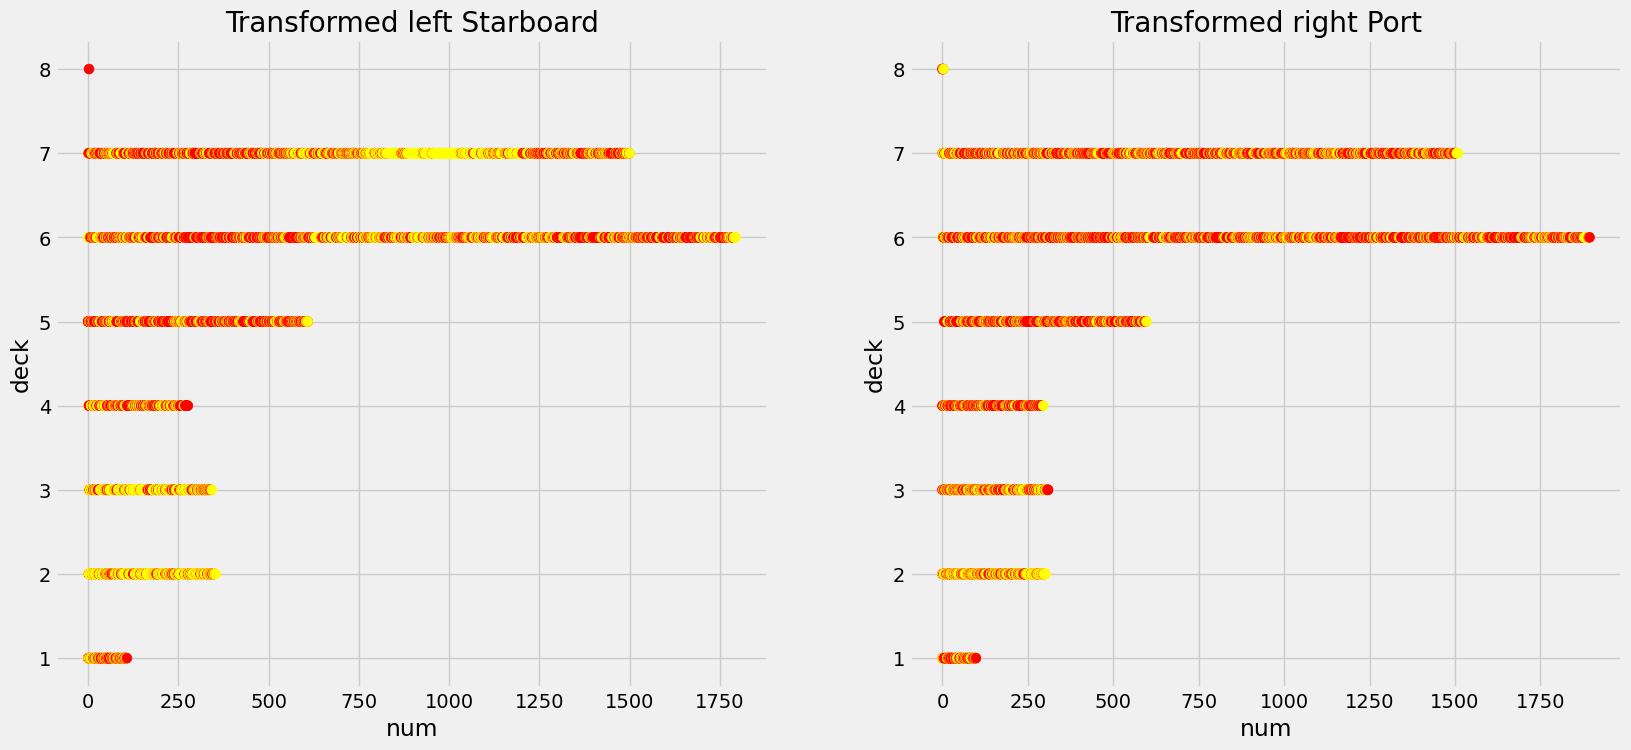

In [359]:
# left = df[df['side'] == 1]
# right = df[df['side'] == -1]
# f,ax=plt.subplots(1,2,figsize=(18,8))
# # plt.scatter(myImputer_data['curv_excess'], myImputer_data['curv_std'], 
# #             c=myImputer_data['target'], s=50, cmap='autumn')
# ax[0].scatter(left['num'], left['deck'], 
#             c=left['target'], s=50, cmap='autumn')
# ax[0].set_title('Transformed left Starboard')
# ax[0].set_xlabel('num')
# ax[0].set_ylabel('deck')
# ax[1].scatter(right['num'], right['deck'], 
#             c=right['target'], s=50, cmap='autumn')
# ax[1].set_title('Transformed right Port')
# ax[1].set_xlabel('num')
# ax[1].set_ylabel('deck')
print('Port vs Star sides')

In [34]:
cols = ['home', 'deck', 'num', 'side', 'dest']
df['fhome'].unique(), df['fdest'].unique()


(array(['Europa', 'Earth', 'Mars', nan], dtype=object),
 array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e', nan], dtype=object))

In [5]:
df['fhome'] = df.loc[:, ['fhome', 'deck']].apply(lambda x: 'Earth' if x[1] == 7 else x[0], axis=1)
df['fhome'] = df.loc[:, ['fhome', 'deck']].apply(lambda x: 'Europa' if x[1] in (1,2,3,8) else x[0], axis=1)

In [ ]:
# кол-во незанятых кают (их можно назначить тем у кого не указаны, но это потом)
# for i in range(1, 9):
#     pside = df[(df['deck'] == i)&(df['side']==1)]['num'].max()
#     sside = df[(df['deck'] == i)&(df['side']==-1)]['num'].max()
#     cab_count_pside = len(df[(df['deck'] == i)&(df['side']==1)]['num'].unique())
#     cab_count_sside = len(df[(df['deck'] == i)&(df['side']==-1)]['num'].unique())
#     print(i,pside, pside - cab_count_pside, '|', sside, sside - cab_count_sside)

In [6]:
df['age'].describe()

count    8514.000000
mean       28.827930
std        14.489021
min         0.000000
25%        19.000000
50%        27.000000
75%        38.000000
max        79.000000
Name: age, dtype: float64

In [7]:
df['age'] = df['age'].fillna(27)

In [8]:
df_home = pd.get_dummies(df['fhome'])

In [9]:
df = pd.merge(df, df_home, left_index=True, right_index=True)


In [10]:
df_dest = pd.get_dummies(df['fdest'])

In [11]:
df = pd.merge(df, df_dest, left_index=True, right_index=True)

In [12]:
df = df.rename(columns={'Earth': 'from_ea', 'Europa':'from_eu', 'Mars':'from_ma', '55 Cancri e': 'to_can',
       'PSO J318.5-22': 'to_pso', 'TRAPPIST-1e': 'to_trap'})

In [13]:
features = ['age', 'deck', 'num', 'side', 'no_expenses', 'from_ea', 'from_eu', 'from_ma', 'to_can', 'to_pso',
       'to_trap']
data = df.loc[:, ['id', 'age', 'deck', 'num', 'side', 'no_expenses', 'from_ea', 'from_eu', 'from_ma', 'to_can', 'to_pso',
       'to_trap', 'target']].copy(deep=True)
data=data.dropna()
data.shape

(8494, 13)

In [14]:
data.isnull().sum()

id             0
age            0
deck           0
num            0
side           0
no_expenses    0
from_ea        0
from_eu        0
from_ma        0
to_can         0
to_pso         0
to_trap        0
target         0
dtype: int64

In [18]:
data=data.astype(np.int64)
data.dtypes

id             int64
age            int64
deck           int64
num            int64
side           int64
no_expenses    int64
from_ea        int64
from_eu        int64
from_ma        int64
to_can         int64
to_pso         int64
to_trap        int64
target         int64
dtype: object

In [19]:
from sklearn.model_selection import train_test_split

In [21]:
X = data.loc[:, features]
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X.columns

Index(['age', 'deck', 'num', 'side', 'no_expenses', 'from_ea', 'from_eu',
       'from_ma', 'to_can', 'to_pso', 'to_trap'],
      dtype='object')

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [24]:
model = SVC()
param_grid = {'kernel': ['rbf', 'linear'], 
              'C': [1, 10],
              'gamma': [0.0001, 0.001]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(X_train, y_train)

Wall time: 4min 39s


GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'gamma': [0.0001, 0.001],
                         'kernel': ['rbf', 'linear']})

In [25]:
grid.best_params_

{'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}

In [26]:
model = grid.best_estimator_
y_predicted = model.predict(X_test)

[Text(0.5, 0, 'Predicted'),
 Text(0, 0.5, 'Actual'),
 Text(0.5, 1.0, 'Confusion Matrix Test Actual vs Predicted')]

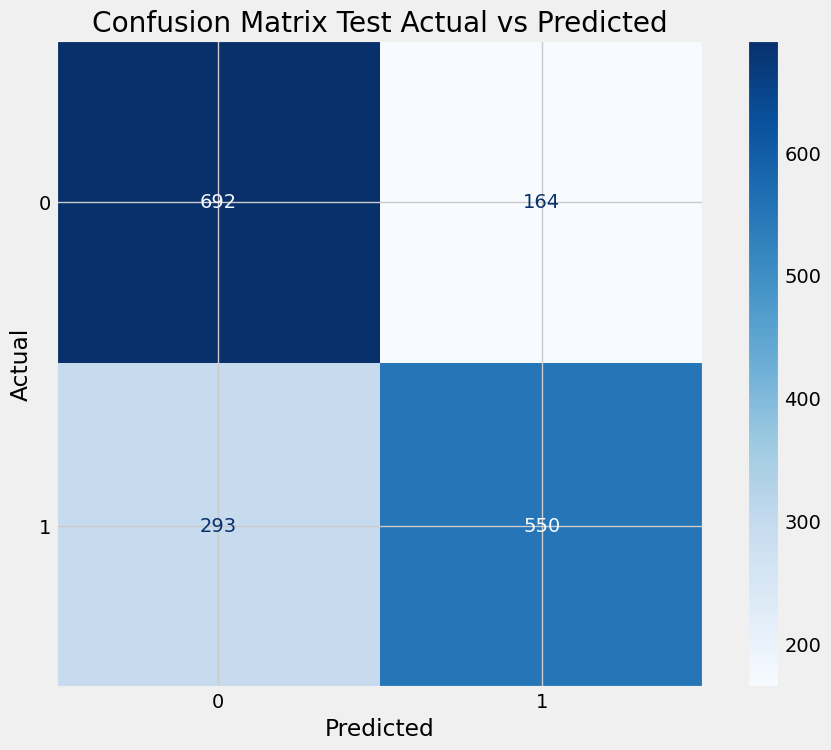

In [28]:
from sklearn import metrics
fig, ax = plt.subplots(figsize=(10,8))
metrics.plot_confusion_matrix(model, X_test, y_test, ax=ax, cmap=plt.cm.Blues)
ax.set(xlabel='Predicted', ylabel='Actual', title='Confusion Matrix Test Actual vs Predicted')

[Text(0.5, 0, 'Train Predicted'),
 Text(0, 0.5, 'Train Actual'),
 Text(0.5, 1.0, 'Confusion Matrix Actual vs Predicted')]

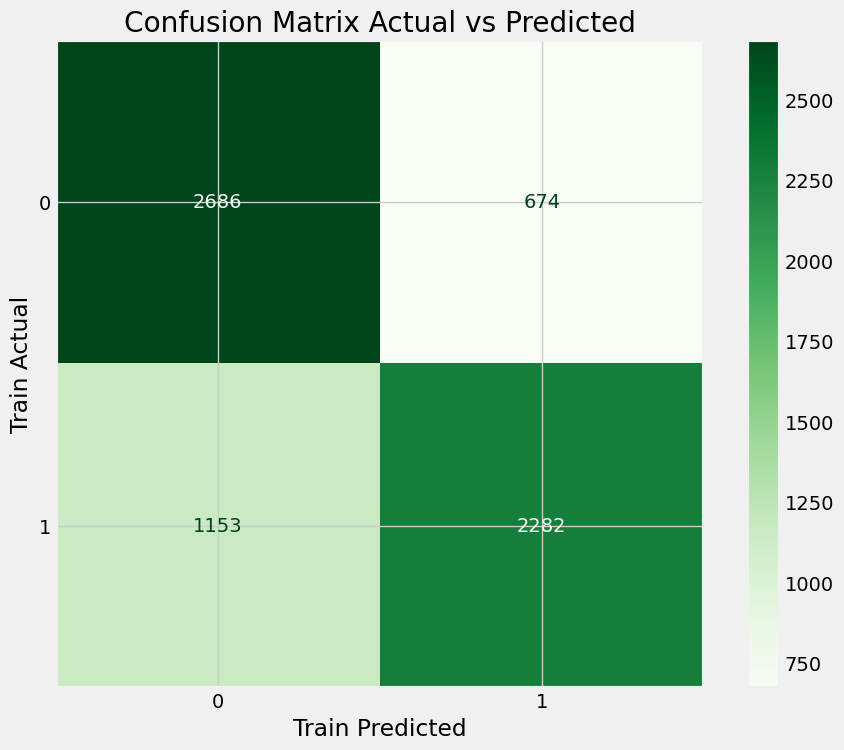

In [29]:
fig, ax = plt.subplots(figsize=(10,8))
metrics.plot_confusion_matrix(model, X_train, y_train, ax=ax, cmap=plt.cm.Greens)
ax.set(xlabel='Train Predicted', ylabel='Train Actual', title='Confusion Matrix Actual vs Predicted')

In [30]:
from sklearn. metrics import classification_report
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.70      0.81      0.75       856
           1       0.77      0.65      0.71       843

    accuracy                           0.73      1699
   macro avg       0.74      0.73      0.73      1699
weighted avg       0.74      0.73      0.73      1699



In [168]:
df_unknown = pd.read_csv('test.csv')
df_unknown = df_unknown .rename(columns=column_alias)    

df_unknown['family'] = df_unknown ['id'].apply(lambda x: x.split('_')[0])

df_unknown['fcab'] = df_unknown['cab']
    
# Оператор *: захват элементов во время распаковки кортежа (tuple)
df_unknown["deck"], df_unknown["num"], df_unknown['side'] = zip(*df_unknown.apply(resolve_cab, axis=1))

df_unknown['famount'] = 1
df_unknown['fhome'] = df_unknown['home']
df_unknown['fdest'] = df_unknown['dest']

df_unknown['famount'] = df_unknown['family'].apply(lambda x: count_relatives(x))
df_unknown['fcab'] = df_unknown.loc[:,['cab', 'family']].apply(lambda x: by_relatives(x[1], 'cab') if pd.isna(x[0]) else x[0], axis=1)


# проставим расходы 0 где is_cryo (если спит значит не тратит, если не тратит  это еще не значит что спит)
for key in ['has_room', 'has_food', 'has_shop', 'has_spa', 'has_vrd']:
    df_unknown[key] =df_unknown.loc[:, [key, 'is_cryo']].apply(lambda x: 0.0 if x[1] else x[0], axis=1)
    
df_unknown['no_expenses'] = np.nan
df_unknown['no_expenses'] = df_unknown.apply(lambda x: int(set_total(x) == 0.), axis=1)
# Заполним пропущенные Home и Destination по родственникам

df_unknown['fhome'] = df_unknown.loc[:,['home', 'family']].apply(lambda x: by_relatives(x[1], 'home') if pd.isna(x[0]) else x[0], axis=1)
df_unknown['fdest'] = df_unknown.loc[:,['dest', 'family']].apply(lambda x: by_relatives(x[1], 'dest') if pd.isna(x[0]) else x[0], axis=1)


df_unknown.head()

,id,home,is_cryo,cab,dest,age,vip,has_room,has_food,has_shop,...,name,family,fcab,deck,num,side,famount,fhome,fdest,no_expenses
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,...,Nelly Carsoning,0013,G/3/S,7.0,3.0,1.0,0,Earth,TRAPPIST-1e,1
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,...,Lerome Peckers,0018,F/4/S,6.0,4.0,1.0,0,Earth,TRAPPIST-1e,0
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,...,Sabih Unhearfus,0019,C/0/S,3.0,0.0,1.0,0,Europa,55 Cancri e,1
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,...,Meratz Caltilter,0021,C/1/S,3.0,1.0,1.0,0,Europa,TRAPPIST-1e,0
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,...,Brence Harperez,0023,F/5/S,6.0,5.0,1.0,0,Earth,TRAPPIST-1e,0


In [133]:
df_unknown.shape

(4277, 22)

In [169]:
df_unknown['fhome'] = df_unknown.loc[:, ['fhome', 'deck']].apply(lambda x: 'Earth' if x[1] == 7 else x[0], axis=1)
df_unknown['fhome'] = df_unknown.loc[:, ['fhome', 'deck']].apply(lambda x: 'Europa' if x[1] in (1,2,3,8) else x[0], axis=1)
df_unknown['age'] = df_unknown['age'].fillna(27)

df_unknown_home = pd.get_dummies(df_unknown['fhome'])
df_unknown = pd.merge(df_unknown, df_unknown_home, left_index=True, right_index=True)


df_unknown_dest = pd.get_dummies(df_unknown['fdest'])
df_unknown = pd.merge(df_unknown, df_unknown_dest, left_index=True, right_index=True)

df_unknown = df_unknown.rename(columns={'Earth': 'from_ea', 'Europa':'from_eu', 'Mars':'from_ma', '55 Cancri e': 'to_can',
       'PSO J318.5-22': 'to_pso', 'TRAPPIST-1e': 'to_trap'})
features = ['age', 'deck', 'num', 'side', 'no_expenses', 'from_ea', 'from_eu', 'from_ma', 'to_can', 'to_pso',
       'to_trap']

df_unknown.shape


(4277, 28)

In [170]:
data_unknown = df_unknown.loc[:, ['id', 'age', 'deck', 'num', 'side', 'no_expenses', 'from_ea', 'from_eu', 'from_ma', 'to_can', 'to_pso',
       'to_trap']].copy(deep=True)

data_unknown.isnull().sum()

id               0
age              0
deck           100
num            100
side           100
no_expenses      0
from_ea          0
from_eu          0
from_ma          0
to_can           0
to_pso           0
to_trap          0
dtype: int64

In [171]:
def set_random_side():
    return 1 if random.uniform(-1, 1)>0 else -1
data_unknown['side'] = data_unknown['side'].apply(lambda x:  set_random_side() if pd.isna(x) else x)

In [172]:
def set_random_deck():
    return int(random.uniform(1, 8.1))
data_unknown['deck'] = data_unknown['deck'].apply(lambda x:  set_random_deck() if pd.isna(x) else x)

In [173]:
num_dict_pside = {}
num_dict_sside = {}
for i in range(1, 9):
    pside = df[(df['deck'] == i)&(df['side']==1)]['num'].max()
    sside = df[(df['deck'] == i)&(df['side']==-1)]['num'].max()
    cab_count_pside = len(df[(df['deck'] == i)&(df['side']==1)]['num'].unique())
    cab_count_sside = len(df[(df['deck'] == i)&(df['side']==-1)]['num'].unique())
    print(i,pside, pside - cab_count_pside, '|', sside, sside - cab_count_sside)
    num_dict_pside[i]=int(pside)
    num_dict_sside[i]=int(sside)
print(num_dict_pside, '\n', num_dict_sside)    

1 107.0 25.0 | 98.0 31.0
2 353.0 110.0 | 301.0 95.0
3 342.0 106.0 | 309.0 109.0
4 276.0 100.0 | 295.0 98.0
5 608.0 218.0 | 597.0 211.0
6 1793.0 636.0 | 1894.0 676.0
7 1500.0 510.0 | 1508.0 501.0
8 2.0 1.0 | 3.0 -1.0
{1: 107, 2: 353, 3: 342, 4: 276, 5: 608, 6: 1793, 7: 1500, 8: 2} 
 {1: 98, 2: 301, 3: 309, 4: 295, 5: 597, 6: 1894, 7: 1508, 8: 3}


In [176]:
def set_random_cab_num(deck, side):
    if side == 1:
        return int(random.uniform(1,  num_dict_pside.get(deck)))
    else:
        return int(random.uniform(1,  num_dict_sside.get(deck)))

data_unknown['num'] = data_unknown.loc[:, ['num','deck', 'side']].apply(lambda x:  set_random_cab_num(x[1], x[2]) if pd.isna(x[0]) else x[0], axis=1)

In [177]:
data_unknown.isnull().sum()

id             0
age            0
deck           0
num            0
side           0
no_expenses    0
from_ea        0
from_eu        0
from_ma        0
to_can         0
to_pso         0
to_trap        0
dtype: int64

In [179]:
data_unknown.shape

(4277, 12)

In [180]:
data_unknown[features]=data_unknown[features].astype(np.int32)
data_unknown.dtypes

id             object
age             int32
deck            int32
num             int32
side            int32
no_expenses     int32
from_ea         int32
from_eu         int32
from_ma         int32
to_can          int32
to_pso          int32
to_trap         int32
dtype: object

In [181]:
data_unknown.shape

(4277, 12)

In [182]:
data_unknown.columns

Index(['id', 'age', 'deck', 'num', 'side', 'no_expenses', 'from_ea', 'from_eu',
       'from_ma', 'to_can', 'to_pso', 'to_trap'],
      dtype='object')

In [183]:

X_un = data_unknown.loc[:, features]
X_un = scaler.transform(X_un)

In [184]:
y_un_predicted = model.predict(X_un)

In [185]:
y_un_predicted.shape

(4277,)

In [186]:
res_header='PassengerId,Transported'
result = zip(data_unknown['id'].tolist(), y_un_predicted)
res_dict = []
for idx, y in result:
    res_dict.append({'PassengerId': idx, 'Transported': bool(y)})
df_res = pd.DataFrame(res_dict)   
df_res

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,False


In [187]:
df_res.to_csv('result.csv', sep=',', header=True, index=False)

In [188]:
data_unknown.shape

(4277, 12)

In [189]:
df_unknown2 = pd.read_csv('test.csv')
df_unknown2.shape

(4277, 13)

In [190]:
from sklearn.tree import DecisionTreeClassifier
clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)


# fit the model
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

In [191]:
y_pred_gini = clf_gini.predict(X_test)

[Text(0.5, 0, 'Tree test Predicted'),
 Text(0, 0.5, 'Tree test Actual'),
 Text(0.5, 1.0, 'Confusion Matrix Actual vs Predicted')]

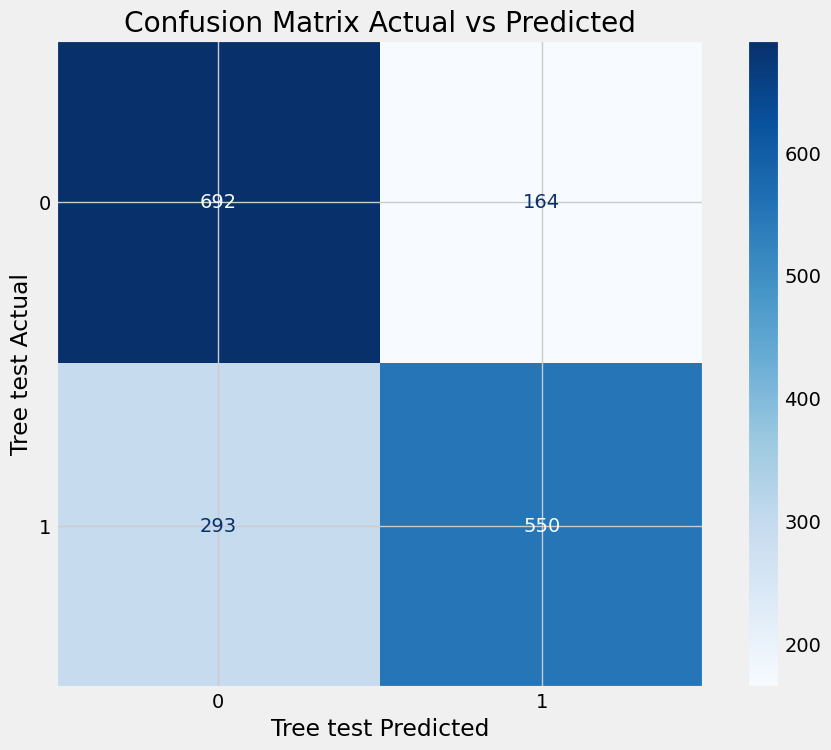

In [192]:
fig, ax = plt.subplots(figsize=(10,8))
metrics.plot_confusion_matrix(clf_gini, X_test, y_test, ax=ax, cmap=plt.cm.Blues)
ax.set(xlabel='Tree test Predicted', ylabel='Tree test Actual', title='Confusion Matrix Actual vs Predicted')

In [193]:
from sklearn. metrics import classification_report
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.70      0.81      0.75       856
           1       0.77      0.65      0.71       843

    accuracy                           0.73      1699
   macro avg       0.74      0.73      0.73      1699
weighted avg       0.74      0.73      0.73      1699

